**Implementación de red asociativa LAM**

**LAM (Memoria Asociativa Lineal)**

Integrantes:
- Alyson Melissa Sánchez Serratos
- Miguel Ángel Pérez Ávila

# Importación de librerías y Variables Gloabales

In [11]:
# Importación de librerías
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [12]:
# Variables GLobales
test_base_path = "../data/test/"
train_base_path = "../data/train/"

# Factores de escalamiento para las imagenes
scale_factor_x = 0.7  
scale_factor_y = 0.7 

# Funciones

In [13]:
# Función de activación con valores donde:
# Si x >= 0: 1
# Si x <  0: 0
def escalonAsimetrico(x):
    if x >=0:
        return 1
    return 0

# Función de activación con valores -1 o 1
# Si x >= 0: 1
# Si x <  0: -1
def escalonSimetrico(x):
    if x >=0:
        return 1
    return -1

def aplicarEscalonAsimetricoAmatrix(x):
    for i in range(len(x)):
        # Se aplica la función para cada valor del vector
        x[i] = escalonAsimetrico(x[i])
    return x

def aplicarEscalonSimetricoAmatrix(x):
    for i in range(len(x)):
        # Se aplica la función para cada valor del vector
        x[i] = escalonSimetrico(x[i])
    return x

In [14]:
def transform_Image2Array(image_array, actFunction):
    newImage = []
    for i in range(len(image_array)):
        auxRow = []
        for j in range(len(image_array[i])):
            if image_array[i][j] == 255:
                if actFunction == "simetrica":
                    auxRow.append(-1)
                else:
                    auxRow.append(0)
            else:
                auxRow.append(1)
        newImage.append(auxRow)

    return newImage

def flattenArray(mat):
    flat = []
    for i in range(len(mat)): # Renglones
        for j in range(len(mat[0])):
            flat.append(mat[i][j])
    flat = np.array(flat, dtype=float)
    return flat

def processImage(path, activationFunction, scale_factor_x, scale_factor_y):
    image_array = cv2.imread(path)

    resized_img = cv2.resize(image_array, None, fx=scale_factor_x, fy=scale_factor_y)

    image_array = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

    newImg = np.array(transform_Image2Array(image_array, activationFunction))
    flatImg = flattenArray(newImg)

    return flatImg

def transform_SimetricBinary2AsimetricBinary(vector):
    newVector=[]
    for i in vector:
        if i == -1:
            newVector.append(0)
        else:
            newVector.append(int(i))
    return newVector

def transform_BinaryVec2str(vector):
    string = ""
    for i in vector:
        string+=str(int(i))
    return string

In [15]:
def random_bool_flip(value, prob=0.2):
    if value:
        return True
    else:
        return np.random.rand() < prob

def transform_Image2Array_withNoise(image_array, actFunction, prob):
    newImage = []
    for i in range(len(image_array)):
        auxRow = []
        for j in range(len(image_array[i])):

            if random_bool_flip(False, prob):
                image_array[i][j] = np.random.choice([255,0], p=[0.5, 0.5])

            if image_array[i][j] == 255:
                if actFunction == "simetrica":
                    auxRow.append(-1)
                else:
                    auxRow.append(0)
            else:
                auxRow.append(1)
            
        newImage.append(auxRow)

    return newImage

def processImageWithNoise(path, activationFunction, scale_factor_x, scale_factor_y, prob):
    image_array = cv2.imread(path)

    resized_img = cv2.resize(image_array, None, fx=scale_factor_x, fy=scale_factor_y)

    image_array = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

    newImg = np.array(transform_Image2Array_withNoise(image_array, activationFunction, prob))
    flatImg = flattenArray(newImg)

    return flatImg

# Implementación LAM (matriz de pesos y bias)

In [16]:
def execLAM(X, Y):
   # Inicializar bias dim = (len(b), )
    bias = np.zeros(shape=(Y.shape[1],))

    # matriz de pesos dim = (len(a), len(b))
    W = np.zeros(shape=(X.shape[1],Y.shape[1]))

    '''
    - Tamaño de W = (len(a), len(b))

    - Calculo de matriz de pesos:
        Wij = sum( xMi*yMj )

        Wij = posición de la matriz de pesos
        sum = sumatoria desde m = 1 hasta la cantidad m de muestras
        xMi = Valor del vector X (para cada muestra m) en la posición i
        yMj = Valor del vector Y (para cada muestra m) en la posición j
    '''
    for i in range(len(W)):
        for j in range(len(W[0])):
            acum = 0
            for m in range(len(X)):
                acum+= (2*X[m][i] - 1)*(2*Y[m][j] - 1)
            W[i,j] = acum

    '''
    El calculo se realiza una vez construida la matriz de pesos.

    - Calculo de bias:
        thetai = -(1/2)*sum(Wij)

        thetai = Valor de bias en la posición i
        sum = sumatoria de j, es decir, se suman todos los valores de un renglon i de la matriz
        Wij = valor de la matriz de pesos en la ubicación de i de theta y j variable en las iteraciones de la sumatoria
    '''
    # Calculo de bias utilizando la matriz de W transpuesta para obtener dimensiones correctas
    # de bias = (len(b), 1) y NO (len(a), 1)
    for i in range(len(W.T)):
        acum = 0
        for j in range(len(W.T[0])):
            acum+= W.T[i, j]
        bias[i] = -(1/2)*acum

    print("W: ",W.shape,"\n",W)
    bias = np.reshape(bias, (bias.shape[0], 1)) # redimensionar bias como vector columna (len(b), 1)
    print("bias: ",bias.shape,"\n", bias)

    return W, bias

In [17]:
def predict(aInput, W, bias, activationfunction):
    # Y_pred = XW + bias 
    result=  np.dot(W.T, aInput) + bias
     # Aplicar al resultado la función de activación deseada para todos los elementos del vector
    if activationfunction== "simetrica":
        result = aplicarEscalonSimetricoAmatrix(result)
    else:
        result = aplicarEscalonAsimetricoAmatrix(result)
        
    return result

# Funcion de Pruebas Automatizadas

In [18]:
def systematicTest(W, bias, sample, y_true, activationFunction, tagIdxDict):
    aInput = np.array(sample)
    aInput = np.reshape(aInput, (aInput.shape[0],1) )
    print("Tag Real...")
    print(y_true)
    newy_true = transform_SimetricBinary2AsimetricBinary(y_true)
    
    print(tagIdxDict[transform_BinaryVec2str(newy_true)])

    print("\nTag Predicho...")
    
    # Prediccion
    y_pred = predict(aInput, W, bias, activationFunction)

    newy_pred = y_pred.T[0]
    print(newy_pred)

    if activationFunction == "simetrica":
        # transformar salida a binario clasico para buscar en el diccionario de clases
        newy_pred = transform_SimetricBinary2AsimetricBinary(newy_pred)
    
    # Buscar directamente
    if transform_BinaryVec2str(newy_pred) in tagIdxDict.keys():
        print(tagIdxDict[transform_BinaryVec2str(newy_pred)])
    else:
        print("Patron Nuevo")


# Entrenamiento LAM | Función de Activación Escalón Simétrico

In [19]:
# Funcion de activación
activationFunction = "simetrica"

## Lectura de Archivos

In [20]:
# Data sets 
Xtrain = []
Ytrain = []
Ytest= []
Xtest = []

# Construcción de conjunto de prueba
tagIdxDict_test = {}
index = 0
for file in sorted(os.listdir(test_base_path)):
        # Procesamiento de imagenes
        image = processImage(test_base_path+file, activationFunction, scale_factor_x, scale_factor_y)
        Xtest.append(image)

        tag = file[0]

        # Obtener etiqueta en notación binaria
        tag_binario = format(index, '05b') 
        
        # Tag_binario -> Vector
        vector = []
        for i in tag_binario:
            if i == "0" and activationFunction == "simetrica":
                vector.append(-1)
            else:
                vector.append(int(i))

        tagIdxDict_test[tag_binario] = tag

        # Añadir la etiqueta al conjunto Y
        Ytest.append(vector)
        index+=1

# Construcción de conjunto de entrenamiento
tagIdxDict_train = {}
index = 0
for file in sorted(os.listdir(train_base_path)):
        image = processImage(train_base_path+file, activationFunction, scale_factor_x, scale_factor_y)
        Xtrain.append(image)

        tag = file[0]

        # Obtener etiqueta en notación binaria
        tag_binario = format(index, '05b') 

        # Tag_binario -> Vector
        vector = []
        for i in tag_binario:
            if i == "0" and activationFunction == "simetrica":
                vector.append(-1)
            else:
                vector.append(int(i))

        tagIdxDict_train[tag_binario] = tag

        # Añadir la etiqueta al conjunto Y
        Ytrain.append(vector)
        index+=1

# Cast de list() a np.array()
Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)
Ytrain = np.array(Ytrain)
Ytest = np.array(Ytest)

print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)

(26, 5476)
(26, 5476)
(26, 5)
(26, 5)


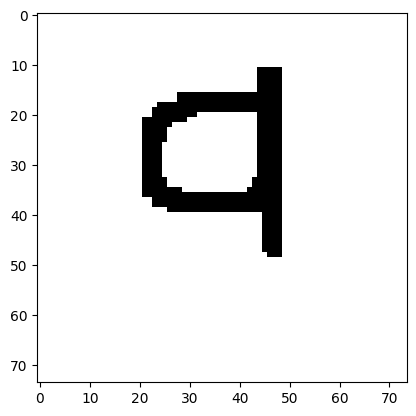

In [21]:
# Mostrar ejemplo de muestra
pixels = 74
input = np.reshape(Xtrain[0], shape=(pixels,pixels))

input2image = np.where(input == -1, 255, 0).astype(np.uint8)

plt.imshow(input2image, cmap='gray', vmin=0, vmax=255)

In [22]:
# Mostrar tags y valores del conjunto de datos
for key, value in tagIdxDict_train.items():
    print("Tag: ", key, "   |  Value: ", value)

Tag:  00000    |  Value:  a
Tag:  00001    |  Value:  b
Tag:  00010    |  Value:  c
Tag:  00011    |  Value:  d
Tag:  00100    |  Value:  e
Tag:  00101    |  Value:  f
Tag:  00110    |  Value:  g
Tag:  00111    |  Value:  h
Tag:  01000    |  Value:  i
Tag:  01001    |  Value:  j
Tag:  01010    |  Value:  k
Tag:  01011    |  Value:  l
Tag:  01100    |  Value:  m
Tag:  01101    |  Value:  n
Tag:  01110    |  Value:  o
Tag:  01111    |  Value:  p
Tag:  10000    |  Value:  q
Tag:  10001    |  Value:  r
Tag:  10010    |  Value:  s
Tag:  10011    |  Value:  t
Tag:  10100    |  Value:  u
Tag:  10101    |  Value:  v
Tag:  10110    |  Value:  w
Tag:  10111    |  Value:  x
Tag:  11000    |  Value:  y
Tag:  11001    |  Value:  z


## Separación de Conjuntos

In [23]:
# Indices de separación para el conjunto de prueba y entrenamiento
idx = 10
idx_sup = 14
m = idx_sup-idx

Xtrain_simetric = Xtrain[idx:idx_sup, :]
Xtest_simetric = Xtest[idx:idx_sup, :]
Ytrain_simetric = Ytrain[idx:idx_sup]
Ytest_simetric = Ytest[idx:idx_sup]
print(Xtrain_simetric.shape)
print(Xtest_simetric.shape)
print(Ytrain_simetric.shape)
print(Ytest_simetric.shape)

(4, 5476)
(4, 5476)
(4, 5)
(4, 5)


## Entrenamiento

In [ ]:
optimizedW, optimizedBias = execLAM(Xtrain_simetric, Ytrain_simetric)

## Predicciones

### Utilizando las Muestras de Entrenamiento

In [25]:
sample_M = 0
systematicTest(optimizedW, optimizedBias, Xtrain_simetric[sample_M], Ytrain_simetric[sample_M], activationFunction, tagIdxDict_train)

Tag Real...
[-1  1 -1  1 -1]
k

Tag Predicho...
[-1.  1. -1. -1. -1.]
i


In [26]:
M=m
for m in range(M):
    print("================ Test: ", m)
    systematicTest(optimizedW, optimizedBias, Xtrain_simetric[m], Ytrain_simetric[m], activationFunction, tagIdxDict_train)

================ Test:  0
Tag Real...
[-1  1 -1  1 -1]
k

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  1
Tag Real...
[-1  1 -1  1  1]
l

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  2
Tag Real...
[-1  1  1 -1 -1]
m

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  3
Tag Real...
[-1  1  1 -1  1]
n

Tag Predicho...
[-1.  1. -1. -1. -1.]
i


### Utilizando las Muestras de Prueba - Ruido de Forma

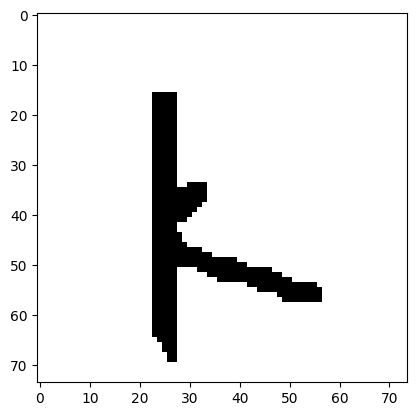

In [27]:
input = np.reshape(Xtest_simetric[0], shape=(pixels,pixels))

input2image = np.where(input == -1, 255, 0).astype(np.uint8)

plt.imshow(input2image, cmap='gray', vmin=0, vmax=255)

In [28]:
for m in range(M):
    print("================ Test: ", m)
    systematicTest(optimizedW, optimizedBias, Xtest_simetric[m], Ytest_simetric[m], activationFunction, tagIdxDict_test)


================ Test:  0
Tag Real...
[-1  1 -1  1 -1]
k

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  1
Tag Real...
[-1  1 -1  1  1]
l

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  2
Tag Real...
[-1  1  1 -1 -1]
m

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  3
Tag Real...
[-1  1  1 -1  1]
n

Tag Predicho...
[-1.  1. -1. -1. -1.]
i


### Utilizando las Muestras de Prueba - Ruido de Bits aleatorios - Factor 0.2

#### Transformar Muestras de entrenamiento a añadiendo ruido a las imagenes de acuerdo con una probabilidad de activación para cada pixel

In [29]:
Xtest_noise_simetric = []
Ytest_noise_simetric = []

noiseProb = 0.2

# Construcción de conjunto de prueba con ruido
tagIdxDict_test_noise = {}
index = 0
for file in sorted(os.listdir(train_base_path)):
        image = processImageWithNoise(train_base_path+file, activationFunction, scale_factor_x, scale_factor_y, noiseProb)
        Xtest_noise_simetric.append(image)

        tag = file[0]

        # Obtener etiqueta en formato binario
        tag_binario = format(index, '05b') 

        # Tag_binario -> Vector
        vector = []
        for i in tag_binario:
            if i == "0" and activationFunction == "simetrica":
                vector.append(-1)
            else:
                vector.append(int(i))

        tagIdxDict_test_noise[tag_binario] = tag

        # Añadir etiqueta al vector Y
        Ytest_noise_simetric.append(vector)
        index+=1

Xtest_noise_simetric = np.array(Xtest_noise_simetric)
Ytest_noise_simetric = np.array(Ytest_noise_simetric)

print(Xtest_noise_simetric.shape)
print(Ytest_noise_simetric.shape)

(26, 5476)
(26, 5)


In [30]:
Xtest_noise_simetric = Xtest_noise_simetric[idx:idx_sup, :]
Ytest_noise_simetric = Ytest_noise_simetric[idx:idx_sup]
print(Xtest_noise_simetric.shape)
print(Ytest_noise_simetric.shape)

(4, 5476)
(4, 5)


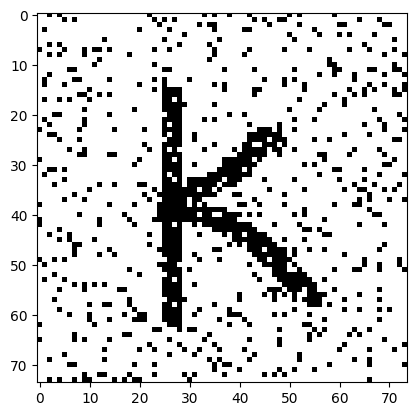

In [31]:
input = np.reshape(Xtest_noise_simetric[0], shape=(pixels,pixels))

input2image = np.where(input == -1, 255, 0).astype(np.uint8)

plt.imshow(input2image, cmap='gray', vmin=0, vmax=255)

#### Ejecución de Pruebas

In [32]:
for m in range(M):
    print("================ Test: ", m)
    systematicTest(optimizedW, optimizedBias, Xtest_noise_simetric[m], Ytest_noise_simetric[m], activationFunction, tagIdxDict_test_noise)

================ Test:  0
Tag Real...
[-1  1 -1  1 -1]
k

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  1
Tag Real...
[-1  1 -1  1  1]
l

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  2
Tag Real...
[-1  1  1 -1 -1]
m

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  3
Tag Real...
[-1  1  1 -1  1]
n

Tag Predicho...
[-1.  1. -1. -1. -1.]
i


### Utilizando las Muestras de Prueba - Ruido de Bits aleatorios - Factor 0.75

#### Transformar Muestras de entrenamiento a añadiendo ruido a las imagenes de acuerdo con una probabilidad de activación para cada pixel

In [33]:
Xtest_noise_simetric = []
Ytest_noise_simetric = []

noiseProb = 0.75

# Construcción de conjunto de prueba con ruido
tagIdxDict_test_noise = {}
index = 0
for file in sorted(os.listdir(train_base_path)):
        image = processImageWithNoise(train_base_path+file, activationFunction, scale_factor_x, scale_factor_y, noiseProb)
        Xtest_noise_simetric.append(image)
        
        tag = file[0]

        # Obtener etiqueta en formato binario
        tag_binario = format(index, '05b') 

        # Tag_binario -> Vector
        vector = []
        for i in tag_binario:
            if i == "0" and activationFunction == "simetrica":
                vector.append(-1)
            else:
                vector.append(int(i))

        tagIdxDict_test_noise[tag_binario] = tag

        # Añadir etiqueta al conjunto Y
        Ytest_noise_simetric.append(vector)
        index+=1

Xtest_noise_simetric = np.array(Xtest_noise_simetric)
Ytest_noise_simetric = np.array(Ytest_noise_simetric)

print(Xtest_noise_simetric.shape)
print(Ytest_noise_simetric.shape)

(26, 5476)
(26, 5)


In [34]:
Xtest_noise_simetric = Xtest_noise_simetric[idx:idx_sup, :]
Ytest_noise_simetric = Ytest_noise_simetric[idx:idx_sup]
print(Xtest_noise_simetric.shape)
print(Ytest_noise_simetric.shape)

(4, 5476)
(4, 5)


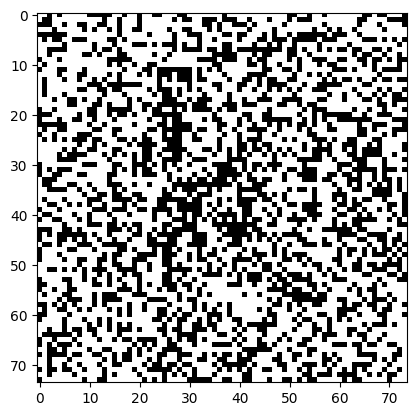

In [35]:
input = np.reshape(Xtest_noise_simetric[0], shape=(pixels,pixels))

input2image = np.where(input == -1, 255, 0).astype(np.uint8)

plt.imshow(input2image, cmap='gray', vmin=0, vmax=255)

#### Ejecución de Pruebas

In [36]:
for m in range(M):
    print("================ Test: ", m)
    systematicTest(optimizedW, optimizedBias, Xtest_noise_simetric[m], Ytest_noise_simetric[m], activationFunction, tagIdxDict_test_noise)


================ Test:  0
Tag Real...
[-1  1 -1  1 -1]
k

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  1
Tag Real...
[-1  1 -1  1  1]
l

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  2
Tag Real...
[-1  1  1 -1 -1]
m

Tag Predicho...
[-1.  1. -1. -1. -1.]
i
================ Test:  3
Tag Real...
[-1  1  1 -1  1]
n

Tag Predicho...
[-1.  1. -1. -1. -1.]
i


# Entrenamiento LAM | Función de Activación Escalón Asimétrico 

In [37]:
# Función de activación
activationFunction = "asimetrica"

## Lectura de Archivos

In [38]:
# Data sets 
Xtrain = []
Ytrain = []
Ytest= []
Xtest = []

# Construcción de conjunto de prueba
tagIdxDict_test = {}
index = 0
for file in sorted(os.listdir(test_base_path)):
        # Procesamiento de imagenes
        image = processImage(test_base_path+file, activationFunction, scale_factor_x, scale_factor_y)
        Xtest.append(image)

        tag = file[0]

        # Obtener etiqueta en formato binario
        tag_binario = format(index, '05b') 
        
        # Tag_binario -> Vector
        vector = []
        for i in tag_binario:
            if i == "0" and activationFunction == "simetrica":
                vector.append(-1)
            else:
                vector.append(int(i))

        tagIdxDict_test[tag_binario] = tag

        # Añadir etiqueta a vector Y
        Ytest.append(vector)
        index+=1

# Construcción de conjunto de entrenamiento
tagIdxDict_train = {}
index = 0
for file in sorted(os.listdir(train_base_path)):
        # Procesamiento de imagenes
        image = processImage(train_base_path+file, activationFunction, scale_factor_x, scale_factor_y)
        Xtrain.append(image)
        
        tag = file[0]

        # Obtener etiqueta en formato binario
        tag_binario = format(index, '05b') 

        # Tag_binario -> Vector
        vector = []
        for i in tag_binario:
            if i == "0" and activationFunction == "simetrica":
                vector.append(-1)
            else:
                vector.append(int(i))

        tagIdxDict_train[tag_binario] = tag

        # Añadir etiqueta a vector Y
        Ytrain.append(vector)
        index+=1

Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)
Ytrain = np.array(Ytrain)
Ytest = np.array(Ytest)

print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)

(26, 5476)
(26, 5476)
(26, 5)
(26, 5)


In [39]:
Xtrain_asimetric = Xtrain[idx:idx_sup, :]
Xtest_asimetric = Xtest[idx:idx_sup, :]
Ytrain_asimetric = Ytrain[idx:idx_sup]
Ytest_asimetric = Ytest[idx:idx_sup]
print(Xtrain_asimetric.shape)
print(Xtest_asimetric.shape)
print(Ytrain_asimetric.shape)
print(Ytest_asimetric.shape)

(4, 5476)
(4, 5476)
(4, 5)
(4, 5)


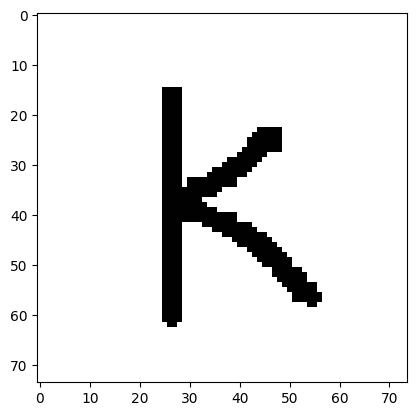

In [40]:
input = np.reshape(Xtrain_asimetric[0], shape=(pixels,pixels))

input2image = np.where(input == 0, 255, 1).astype(np.uint8)

plt.imshow(input2image, cmap='gray', vmin=0, vmax=255)

## Entrenamiento

In [ ]:
optimizedW, optimizedBias = execLAM(Xtrain_asimetric, Ytrain_asimetric)

## Predicciones

### Utilizando las Muestras de Entrenamiento

In [42]:
sample_M = 0
systematicTest(optimizedW, optimizedBias, Xtrain_asimetric[sample_M], Ytrain_asimetric[sample_M], activationFunction, tagIdxDict_train)

Tag Real...
[0 1 0 1 0]
k

Tag Predicho...
[0. 1. 0. 1. 0.]
k


In [43]:
for m in range(M):
    print("================ Test: ", m)
    systematicTest(optimizedW, optimizedBias, Xtrain_asimetric[m], Ytrain_asimetric[m], activationFunction, tagIdxDict_train)


================ Test:  0
Tag Real...
[0 1 0 1 0]
k

Tag Predicho...
[0. 1. 0. 1. 0.]
k
================ Test:  1
Tag Real...
[0 1 0 1 1]
l

Tag Predicho...
[0. 1. 0. 1. 1.]
l
================ Test:  2
Tag Real...
[0 1 1 0 0]
m

Tag Predicho...
[0. 1. 1. 0. 0.]
m
================ Test:  3
Tag Real...
[0 1 1 0 1]
n

Tag Predicho...
[0. 1. 1. 0. 1.]
n


### Utilizando las Muestras de Prueba - Ruido de Forma

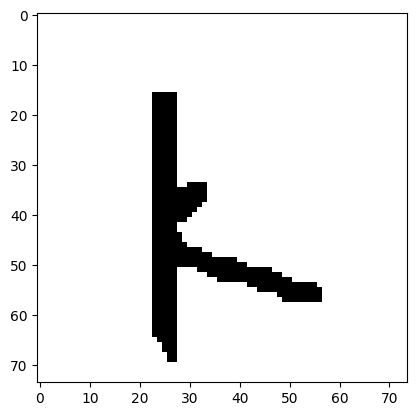

In [44]:
input = np.reshape(Xtest_simetric[0], shape=(pixels,pixels))

input2image = np.where(input == -1, 255, 0).astype(np.uint8)

plt.imshow(input2image, cmap='gray', vmin=0, vmax=255)

In [45]:
for m in range(M):
    print("================ Test: ", m)
    systematicTest(optimizedW, optimizedBias, Xtest_asimetric[m], Ytest_asimetric[m], activationFunction, tagIdxDict_test)


================ Test:  0
Tag Real...
[0 1 0 1 0]
k

Tag Predicho...
[0. 1. 0. 1. 1.]
l
================ Test:  1
Tag Real...
[0 1 0 1 1]
l

Tag Predicho...
[0. 1. 0. 1. 1.]
l
================ Test:  2
Tag Real...
[0 1 1 0 0]
m

Tag Predicho...
[0. 1. 1. 0. 1.]
n
================ Test:  3
Tag Real...
[0 1 1 0 1]
n

Tag Predicho...
[0. 1. 0. 1. 1.]
l


### Utilizando las Muestras de Prueba - Ruido de Bits aleatorios - Factor 0.2

#### Transformar Muestras de entrenamiento a añadiendo ruido a las imagenes de acuerdo con una probabilidad de activación para cada pixel

In [46]:
Xtest_noise_asimetric = []
Ytest_noise_asimetric = []

noiseProb = 0.2

# COnstrucción de conjunto de prueba con ruido
tagIdxDict_test_noise = {}
index = 0
for file in sorted(os.listdir(train_base_path)):
        image = processImageWithNoise(train_base_path+file, activationFunction, scale_factor_x, scale_factor_y, noiseProb)
        Xtest_noise_asimetric.append(image)

        tag = file[0]

        # Obtener etiqueta en formato binario 
        tag_binario = format(index, '05b') 

        # Tag_binario -> Vector
        vector = []
        for i in tag_binario:
            if i == "0" and activationFunction == "simetrica":
                vector.append(-1)
            else:
                vector.append(int(i))

        tagIdxDict_test_noise[tag_binario] = tag

        # Añadir etiqueta al conjunto Y
        Ytest_noise_asimetric.append(vector)
        index+=1

Xtest_noise_asimetric = np.array(Xtest_noise_asimetric)
Ytest_noise_asimetric = np.array(Ytest_noise_asimetric)

print(Xtest_noise_asimetric.shape)
print(Ytest_noise_asimetric.shape)

(26, 5476)
(26, 5)


In [47]:
Xtest_noise_asimetric = Xtest_noise_asimetric[idx:idx_sup, :]
Ytest_noise_asimetric = Ytest_noise_asimetric[idx:idx_sup]
print(Xtest_noise_asimetric.shape)
print(Ytest_noise_asimetric.shape)

(4, 5476)
(4, 5)


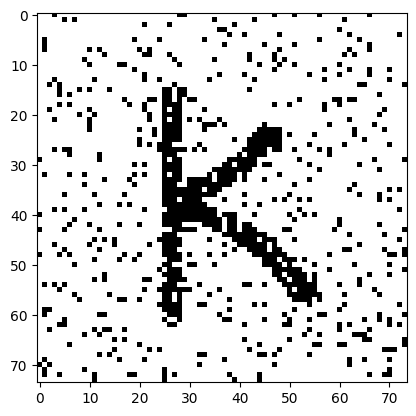

In [48]:
input = np.reshape(Xtest_noise_asimetric[0], shape=(pixels,pixels))

input2image = np.where(input == 0, 255, 0).astype(np.uint8)

plt.imshow(input2image, cmap='gray', vmin=0, vmax=255)

#### Ejecución de Pruebas

In [49]:
for m in range(M):
    print("================ Test: ", m)
    systematicTest(optimizedW, optimizedBias, Xtest_noise_asimetric[m], Ytest_noise_asimetric[m], activationFunction, tagIdxDict_test_noise)


================ Test:  0
Tag Real...
[0 1 0 1 0]
k

Tag Predicho...
[0. 1. 0. 1. 0.]
k
================ Test:  1
Tag Real...
[0 1 0 1 1]
l

Tag Predicho...
[0. 1. 0. 1. 1.]
l
================ Test:  2
Tag Real...
[0 1 1 0 0]
m

Tag Predicho...
[0. 1. 1. 0. 0.]
m
================ Test:  3
Tag Real...
[0 1 1 0 1]
n

Tag Predicho...
[0. 1. 1. 0. 1.]
n


### Utilizando las Muestras de Prueba - Ruido de Bits aleatorios - Factor 0.75

#### Transformar Muestras de entrenamiento a añadiendo ruido a las imagenes de acuerdo con una probabilidad de activación para cada pixel

In [50]:
Xtest_noise_asimetric = []
Ytest_noise_asimetric = []

noiseProb = 0.75

# Construcción del conjunto de prueba con ruido
tagIdxDict_test_noise = {}
index = 0
for file in sorted(os.listdir(train_base_path)):
        # Procesamiento de imagenes
        image = processImageWithNoise(train_base_path+file, activationFunction, scale_factor_x, scale_factor_y, noiseProb)
        Xtest_noise_asimetric.append(image)
        tag = file[0]

        # Obtener etiqueta con formato binario 
        tag_binario = format(index, '05b') 

        # Tag_binario -> Vector
        vector = []
        for i in tag_binario:
            if i == "0" and activationFunction == "simetrica":
                vector.append(-1)
            else:
                vector.append(int(i))

        tagIdxDict_test_noise[tag_binario] = tag

        # Añadir etiqueta al conjunto Y
        Ytest_noise_asimetric.append(vector)
        index+=1

Xtest_noise_asimetric = np.array(Xtest_noise_asimetric)
Ytest_noise_asimetric = np.array(Ytest_noise_asimetric)

print(Xtest_noise_asimetric.shape)
print(Ytest_noise_asimetric.shape)

(26, 5476)
(26, 5)


In [51]:
Xtest_noise_asimetric = Xtest_noise_asimetric[idx:idx_sup, :]
Ytest_noise_asimetric = Ytest_noise_asimetric[idx:idx_sup]
print(Xtest_noise_asimetric.shape)
print(Ytest_noise_asimetric.shape)

(4, 5476)
(4, 5)


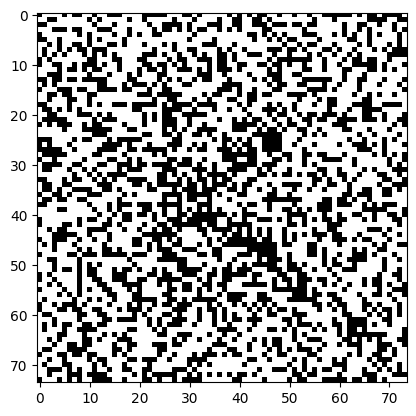

In [52]:
input = np.reshape(Xtest_noise_asimetric[0], shape=(pixels,pixels))

input2image = np.where(input == 0, 255, 0).astype(np.uint8)

plt.imshow(input2image, cmap='gray', vmin=0, vmax=255)

#### Ejecución de Pruebas

In [53]:
for m in range(M):
    print("================ Test: ", m)
    systematicTest(optimizedW, optimizedBias, Xtest_noise_asimetric[m], Ytest_noise_asimetric[m], activationFunction, tagIdxDict_test_noise)


================ Test:  0
Tag Real...
[0 1 0 1 0]
k

Tag Predicho...
[0. 1. 0. 1. 0.]
k
================ Test:  1
Tag Real...
[0 1 0 1 1]
l

Tag Predicho...
[0. 1. 0. 1. 1.]
l
================ Test:  2
Tag Real...
[0 1 1 0 0]
m

Tag Predicho...
[0. 1. 1. 0. 0.]
m
================ Test:  3
Tag Real...
[0 1 1 0 1]
n

Tag Predicho...
[0. 1. 1. 0. 1.]
n
